In [1]:
from pydrive2.drive import GoogleDrive # This import is for interacting with Google Drive using PyDrive
from google.colab import drive # This import is specific to Google Colab environments for mounting the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install opencv-python

In [3]:
# Basic Libraries
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import time
import json
import itertools
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *

# Deep Learning & Computer Vision
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense # Import Flatten and Dense


# Image Processing
from skimage.io import imread
from skimage.transform import resize
from PIL import Image

# Data Handling & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer


# Performance Metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Visualization
from plotly.offline import plot
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

init_notebook_mode(connected=True)

# Set random seed for reproducibility
RANDOM_SEED = 123

print("✅ All required modules have been successfully imported!")

✅ All required modules have been successfully imported!


In [4]:
# Define dataset path
IMG_PATH = '/content/drive/MyDrive/lung_image_sets'

# Define output directories for train, val, and test splits
OUTPUT_DIR ='/content/drive/MyDrive/lung_image_sets'
SPLITS = ["TRAIN", "VAL", "TEST"]
CATEGORIES = {
    "Lung_Benign": "BENIGN",
    "Lung_Adenocarcinoma": "ADENOCARCINOMA",
    "Lung_Squamous_Cell_Carcinoma": "SQUAMOUS"
}

# Create split directories
for split in SPLITS:
    for label in CATEGORIES.values():
        os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)

# Split data into train (80%), val (10%), and test (10%)
for CLASS in os.listdir(IMG_PATH):
    if CLASS in CATEGORIES:
        LABEL = CATEGORIES[CLASS]
        CLASS_PATH = os.path.join(IMG_PATH, CLASS)
        IMG_FILES = os.listdir(CLASS_PATH)
        IMG_NUM = len(IMG_FILES)

        for i, FILE_NAME in enumerate(IMG_FILES):
            src = os.path.join(CLASS_PATH, FILE_NAME)

            if i < 0.1 * IMG_NUM:
                dest = os.path.join(OUTPUT_DIR, "TEST", LABEL, FILE_NAME)
            elif i < 0.9 * IMG_NUM:
                dest = os.path.join(OUTPUT_DIR, "TRAIN", LABEL, FILE_NAME)
            else:
                dest = os.path.join(OUTPUT_DIR, "VAL", LABEL, FILE_NAME)

            shutil.copy(src, dest)

print("Dataset split completed successfully!")

Dataset split completed successfully!


In [5]:
def split_data(source_dir, train_dir, val_dir, test_dir, train_ratio=0.7, val_ratio=0.15):
    """
    Splits the dataset into train, validation, and test sets.
    """
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        # Check if it's a directory (and not a file like a '.DS_Store') and if it is one of the specified categories
        if os.path.isdir(category_path) and category in CATEGORIES:
            images = os.listdir(category_path)
            np.random.shuffle(images)

            train_size = int(len(images) * train_ratio)
            val_size = int(len(images) * val_ratio)

            train_images = images[:train_size]
            val_images = images[train_size:train_size + val_size]
            test_images = images[train_size + val_size:]

            for image in train_images:
                src_path = os.path.join(category_path, image)
                dst_path = os.path.join(train_dir, category, image)
                if not os.path.exists(os.path.dirname(dst_path)):
                    os.makedirs(os.path.dirname(dst_path))
                shutil.copy(src_path, dst_path)

            for image in val_images:
                src_path = os.path.join(category_path, image)
                dst_path = os.path.join(val_dir, category, image)
                if not os.path.exists(os.path.dirname(dst_path)):
                    os.makedirs(os.path.dirname(dst_path))
                shutil.copy(src_path, dst_path)

            for image in test_images:
                src_path = os.path.join(category_path, image)
                dst_path = os.path.join(test_dir, category, image)
                if not os.path.exists(os.path.dirname(dst_path)):
                    os.makedirs(os.path.dirname(dst_path))
                shutil.copy(src_path, dst_path)

            print(f"Category: {category} -> Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

# Define Paths
# Assuming IMG_PATH is the path to your original dataset containing subfolders for each class
SOURCE_DIR = IMG_PATH #  '/content/lung image set' # Correct path to your original dataset
TRAIN_DIR = '/content/drive/MyDrive/lung_image_sets/TRAIN'
VAL_DIR = '/content/drive/MyDrive/lung_image_sets/VAL'
TEST_DIR = '/content/drive/MyDrive/lung_image_sets/TEST'

# Split dataset
split_data(SOURCE_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR)

In [6]:
!pip install tqdm

In [7]:
def load_data(dir_path, img_size=(128,128)):
    """
    Load resized images as np.arrays.
    """
    import cv2
    import numpy as np # Import numpy here
    import os
    from tqdm import tqdm # Import tqdm here

    X = []
    y = []
    labels = {}
    i = 0
    # Define IMG_PATH inside the function
    IMG_PATH = '/content/drive/MyDrive/lung_image_sets'
    # Get the absolute path for the image directory
    abs_dir_path = os.path.join(IMG_PATH, dir_path)

    for path in tqdm(sorted(os.listdir(dir_path))):
        full_path = os.path.join(dir_path, path)
        if os.path.isdir(full_path):  # Ensure it's a folder
            labels[i] = path  # Store label mapping
            for file in os.listdir(full_path):
                img_path = os.path.join(full_path, file)
                if file.lower().endswith(('png', 'jpg', 'jpeg')):  # Process only image files
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size)  # Resize to ResNet-50 input size
                    X.append(img)
                    y.append(i)
            i += 1

    X = np.array(X) / 255.0  # Normalize images
    y = np.array(y)

    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels # Changed 'label' to 'labels'

In [8]:
TRAIN_DIR = '/content/drive/MyDrive/lung_image_sets/TRAIN'
TEST_DIR = '/content/drive/MyDrive/lung_image_sets/TEST'
VAL_DIR = '/content/drive/MyDrive/lung_image_sets/VAL'
IMG_SIZE = (128,128)

In [9]:
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 3/3 [00:54<00:00, 18.13s/it]


1958 images loaded from /content/drive/MyDrive/lung_image_sets/TRAIN directory.


100%|██████████| 3/3 [00:21<00:00,  7.14s/it]


1071 images loaded from /content/drive/MyDrive/lung_image_sets/TEST directory.


100%|██████████| 3/3 [00:19<00:00,  6.53s/it]

1009 images loaded from /content/drive/MyDrive/lung_image_sets/VAL directory.


In [10]:
import numpy as np
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [11]:
!pip install plotly
import plotly.io as pio
pio.renderers.default = "colab"

In [12]:
#Plotting the number of samples in Training, Validation and Test sets
# Dictionary to store class counts
import plotly.graph_objects as go
y_counts = {0: [], 1: [], 2: []}  # Three classes

# Count occurrences of each class in train, val, and test sets
for dataset in (y_train, y_val, y_test):
    y_counts[0].append(np.sum(dataset == 0))  # Lung benign tissue
    y_counts[1].append(np.sum(dataset == 1))  # Lung adenocarcinoma
    y_counts[2].append(np.sum(dataset == 2))  # Lung squamous cell carcinoma

# Define bar plots for each class
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y_counts[0],
    name='Lung Benign Tissue',
    marker=dict(color='#33cc33'),  # Green color
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y_counts[1],
    name='Lung Adenocarcinoma',
    marker=dict(color='#ff3300'),  # Red color
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y_counts[2],
    name='Lung Squamous Cell Carcinoma',
    marker=dict(color='#3366ff'),  # Blue color
    opacity=0.7
)

# Combine all traces
data = [trace0, trace1, trace2]

# Define layout
layout = go.Layout(
    title='Class Distribution in Train, Validation, and Test Sets',
    xaxis={'title': 'Dataset'},
    yaxis={'title': 'Number of Samples'},
    barmode='group'
)

# Generate plot
fig = go.Figure(data, layout)
fig.show()

In [13]:
import matplotlib.pyplot as plt
def plot_lung_samples(X, y, labels_dict, n=50):
    """
    Displays a grid of lung tumor images (n per class).

    Parameters:
        X: numpy array of images.
        y: numpy array of labels.
        labels_dict: Dictionary mapping label indices to class names.
        n: Number of images to display per class.
    """
    for index in range(len(labels_dict)):  # Loop through classes
        imgs = X[np.argwhere(y == index)][:n]  # Select 'n' images for each class
        num_cols = 10  # Number of images per row
        num_rows = int(np.ceil(n / num_cols))  # Compute number of rows

        plt.figure(figsize=(15, 6))
        count = 1
        for img in imgs:
            plt.subplot(num_rows, num_cols, count)
            plt.imshow(img[0])
            plt.xticks([])
            plt.yticks([])
            count += 1

        plt.suptitle(f'Lung Tumor Category: {labels_dict[index]}', fontsize=14)
        plt.show()

# Example labels dictionary
labels_dict = {
    0: "Lung Benign Tissue",
    1: "Lung Adenocarcinoma",
    2: "Lung Squamous Cell Carcinoma"
}

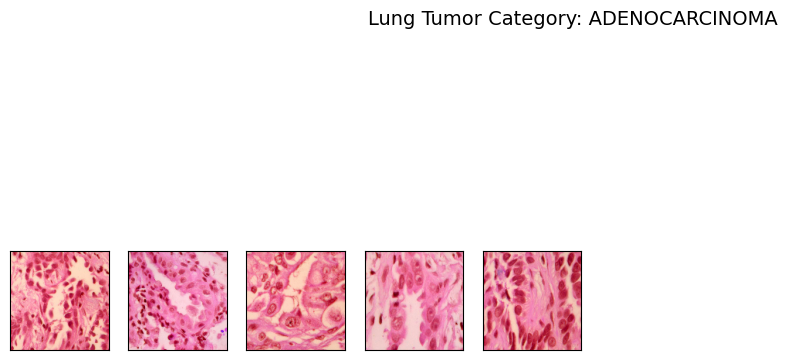

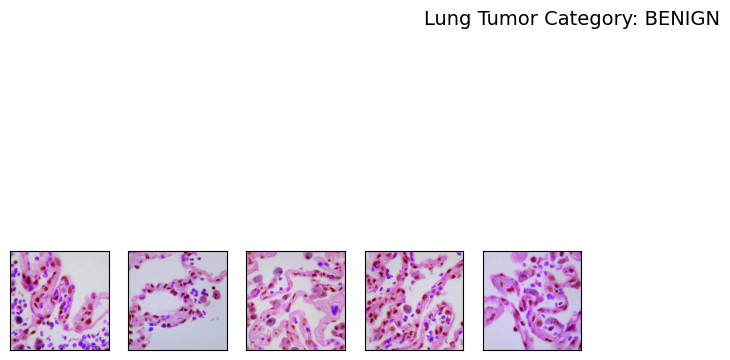

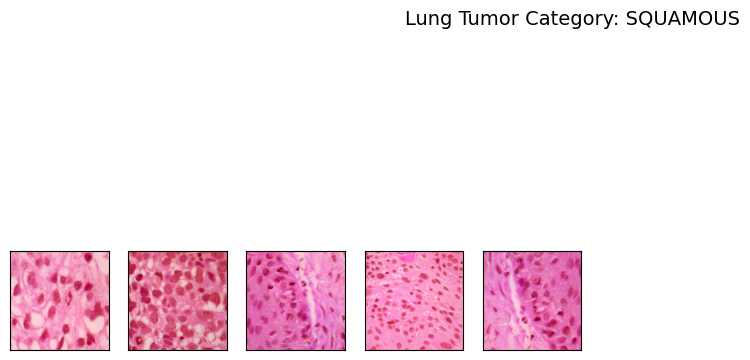

In [14]:
plot_lung_samples(X_train, y_train, labels, 5)

Found 1568 images belonging to 3 classes.
Found 390 images belonging to 3 classes.
Class Weights: {0: np.float64(0.7239150507848569), 1: np.float64(0.8858757062146893), 2: np.float64(2.0416666666666665)}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.4221 - loss: 1.2113 - val_accuracy: 0.5590 - val_loss: 0.9111 - learning_rate: 1.0000e-04
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.6300 - loss: 0.9330 - val_accuracy: 0.5974 - val_loss: 0.8738 - learning_rate: 5.0000e-05
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.6153 - loss: 0.9270 - val_accuracy: 0.7487 - val_loss: 0.8378 - learning_rate: 5.0000e-05
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 714ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step

📊 Classification Report:
                precision    recall  f1-score   support

ADENOCARCINOMA       0.86      0.54      0.67       180
        BENIGN       0.93      0.96      0.95       147
      SQUAMOUS       0.42      0.84      0.56        63

      accuracy      

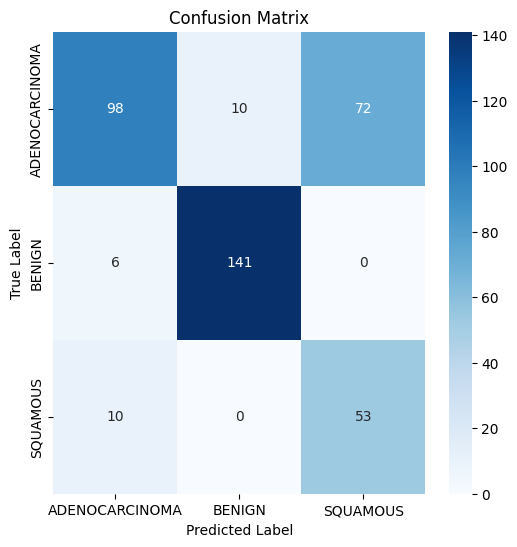

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# ✅ Config
DATA_DIR = '/content/drive/MyDrive/lung_image_sets/TRAIN'
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 3
VALIDATION_SPLIT = 0.2

# ✅ Focal Loss Function
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1 - 1e-7)
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.sum(loss, axis=1)
    return loss

# ✅ Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=VALIDATION_SPLIT
)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=VALIDATION_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=True, seed=42
)
val_generator = val_datagen.flow_from_directory(
    DATA_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

# ✅ Class Weights
class_indices = train_generator.class_indices
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# ✅ Even Shallower ResNet Variant
def shallow_resnet_model(input_shape=(128, 128, 3), num_classes=3):
    base_model_full = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model = Model(inputs=base_model_full.input, outputs=base_model_full.get_layer("conv2_block3_out").output)

    for layer in base_model.layers:
        layer.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = layers.GaussianNoise(0.3)(inputs)
    x = base_model(x, training=False)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# ✅ Compile Model with Label Smoothing
model = shallow_resnet_model(num_classes=len(class_indices))
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    metrics=['accuracy']
)

# ✅ Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=0, restore_best_weights=True
)

def scheduler(epoch, lr):
    return 0.00005 if epoch >= 1 else lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

# ✅ Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

# ✅ Evaluate
y_true = []
y_pred = []
val_generator.reset()
for i in range(len(val_generator)):
    X_batch, y_batch = val_generator[i]
    preds = model.predict(X_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

class_labels = list(val_generator.class_indices.keys())
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ✅ Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


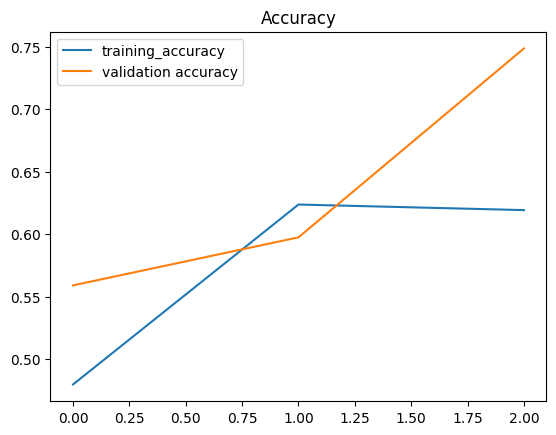

In [16]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

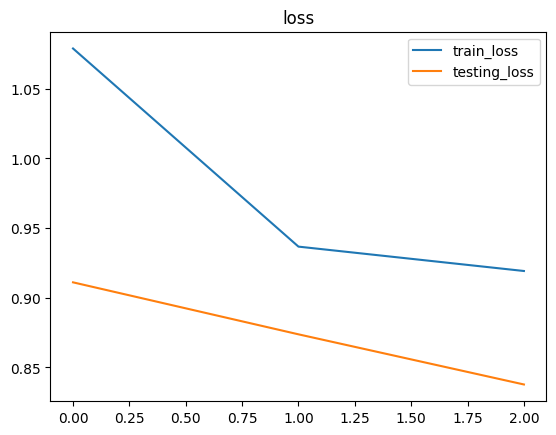

In [17]:
# plotting the loss
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

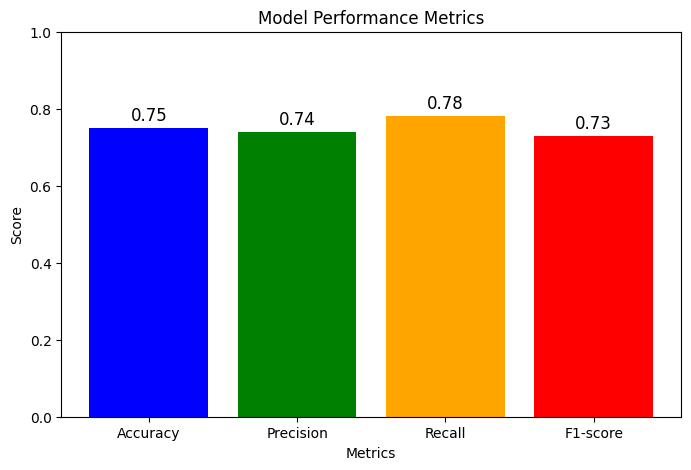

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Example metric values (Replace with actual computed values)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [0.75, 0.74, 0.78, 0.73]  # Replace with actual values

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])

# Adding labels and title
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.ylim(0, 1)  # Scores range from 0 to 1
plt.title('Model Performance Metrics')

# Adding value labels on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, str(round(v, 2)), ha='center', fontsize=12)

# Show the plot
plt.show()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 1958 images belonging to 3 classes.
Found 1009 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 69s 912ms/step - accuracy: 0.5170 - loss: 1.0733 - val_accuracy: 0.8722 - val_loss: 0.5254 - learning_rate: 5.0000e-04
Epoch 2/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 702ms/step - accuracy: 0.7731 - loss: 0.5476 - val_accuracy: 0.8910 - val_loss: 0.3856 - learning_rate: 5.0000e-04
Epoch 3/3
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 706ms/step - accuracy: 0.8256 - loss: 0.4350 - val_accuracy: 0.8930 - val_loss: 0.3287 - learning_rate: 5.0000e-04
Accuracy: 89.30%
Precision: 89.36%
Recall: 89.30%
F1-Score: 89.19%
Confusion Matrix:
 [[467  41  23]
 [  5 287   0]
 [ 39   0 147]]
Classification Report:
                 precision    recall  f1-score   support

ADENOCARCINOMA       0.91      0.88      0.90       531
        BENIGN       0.88      0.98      0.93       292
      SQUAMOUS       0.86      0.79      0.83       186

      accuracy                           0.89      1009
     macro avg       0.88      0.88      0.88      1009
  weighted avg       0.89      0.89   

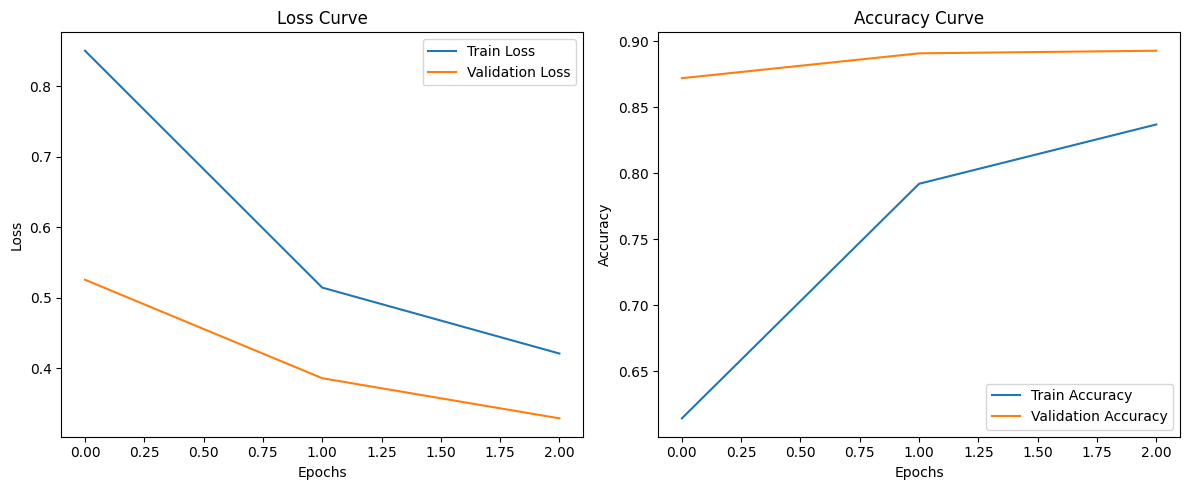

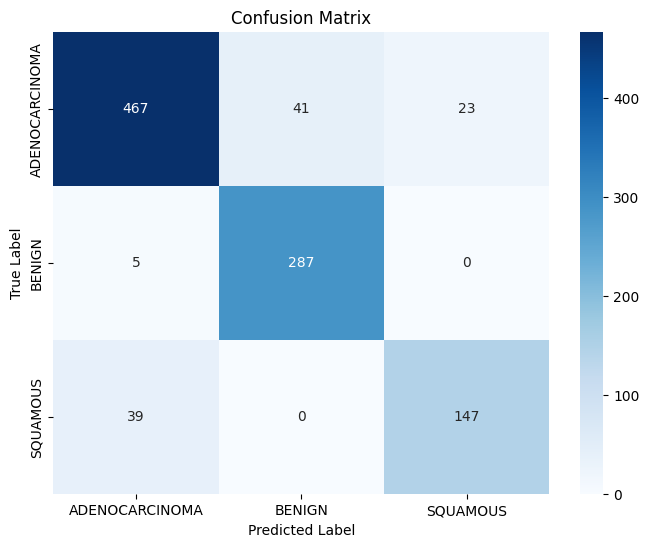

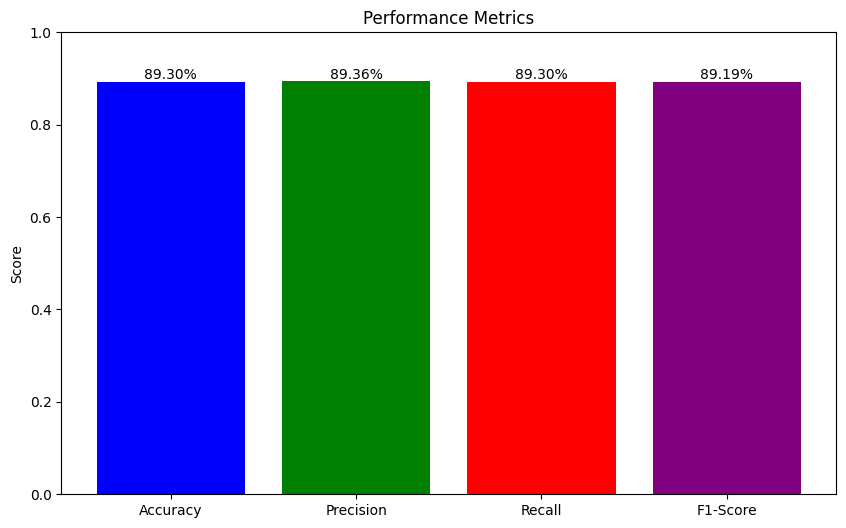

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Pretrained VGG16 Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers (no fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Layers
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)  # Increased dropout to prevent overfitting
outputs = Dense(3, activation='softmax')(x)  # 3-class classification

# Compile Model
model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=SGD(learning_rate=0.0005, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,  # Increased for better generalization
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load Datasets
TRAIN_DIR = '/content/drive/MyDrive/lung_image_sets/TRAIN'
VAL_DIR = '/content/drive/MyDrive/lung_image_sets/VAL'

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Reduce LR if validation loss doesn't improve
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=3e-5)

# Train for 3 Epochs
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=3,  # Reduced from 5 to 3
    callbacks=[lr_reduction],
    verbose=1
)

# Evaluate Model
y_true = []
y_pred = []

# Collect Predictions and True Labels
validation_generator.reset()
for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute Metrics
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100
f1 = f1_score(y_true, y_pred, average='weighted') * 100
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys())

# Print Results
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1:.2f}%")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Plot Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Bar Chart for Metrics
metrics = {
    'Accuracy': accuracy/100,
    'Precision': precision/100,
    'Recall': recall/100,
    'F1-Score': f1/100
}
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'purple'])
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height*100:.2f}%', ha='center', va='bottom')
plt.show()

In [ ]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
image_set = '/content/drive/MyDrive/lung_image_sets'
train='/content/drive/MyDrive/lung_image_sets/TRAIN'
val='/content/drive/MyDrive/lung_image_sets/VAL'
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2)

train_set = datagen.flow_from_directory(train,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128,
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)

validate_set = datagen.flow_from_directory(val,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X, SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128,
                                       shuffle = False,
                                       subset='validation',
                                       seed = 42)

Found 1568 images belonging to 3 classes.
Found 201 images belonging to 3 classes.


In [ ]:
IMAGE_SIZE = [224, 224]
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False
flatten = Flatten()(resnet.output)
dense = Dense(256, activation = 'relu')(flatten)
dense = Dense(128, activation = 'relu')(dense)
prediction = Dense(3, activation = 'softmax')(dense)
#creating a model
model = Model(inputs = resnet.input, outputs = prediction )

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 49,311,363 (188.11 MB)

 Trainable params: 25,723,651 (98.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# COMPILING THE MODEL

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
 #executing the model
history = model.fit(train_set, validation_data = validate_set, epochs = 5, verbose = 1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 391s 29s/step - accuracy: 0.2605 - loss: 45.9554 - val_accuracy: 0.2886 - val_loss: 41.3959
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 374s 29s/step - accuracy: 0.3999 - loss: 34.4123 - val_accuracy: 0.9254 - val_loss: 0.6377
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 361s 28s/step - accuracy: 0.8949 - loss: 0.9480 - val_accuracy: 0.9254 - val_loss: 0.6594
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 369s 28s/step - accuracy: 0.9666 - loss: 0.2553 - val_accuracy: 0.9104 - val_loss: 0.7121
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 359s 28s/step - accuracy: 0.9507 - loss: 0.3237 - val_accuracy: 0.9453 - val_loss: 0.3674


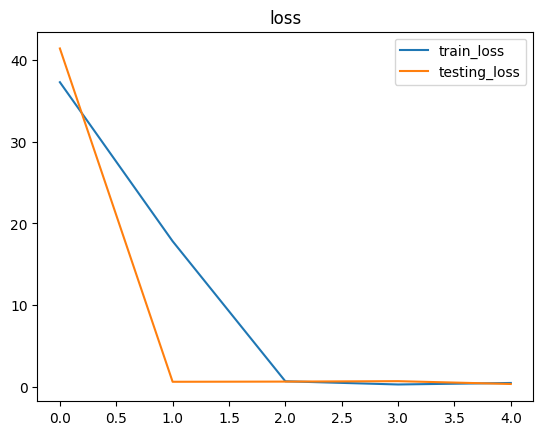

In [ ]:
# plotting the loss
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'testing_loss')
plt.title('loss')
plt.legend()
plt.show()

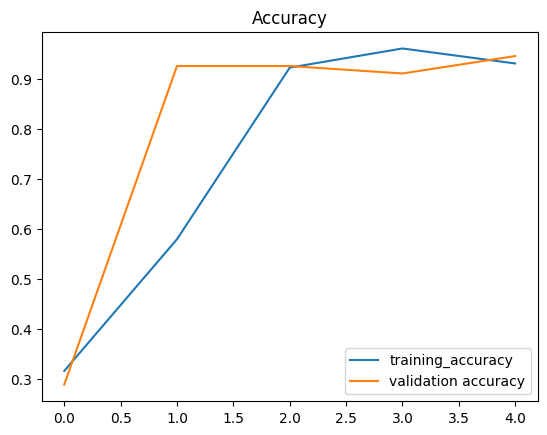

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# CHECKING THE CONFUSION MATRIX
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict(validate_set) # Use model.predict instead of predict_generator
y_pred = np.argmax(Y_pred ,axis =1)
print('Confusion Matrix')
confusion_matrix = confusion_matrix(validate_set.classes, y_pred)
print(confusion_matrix)
print('Classification Report')
target_names = ['aca','n', 'scc']
print(classification_report(validate_set.classes, y_pred, target_names=target_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 16s/step
Confusion Matrix
[[102   0   4]
 [  1  57   0]
 [  6   0  31]]
Classification Report
              precision    recall  f1-score   support

         aca       0.94      0.96      0.95       106
           n       1.00      0.98      0.99        58
         scc       0.89      0.84      0.86        37

    accuracy                           0.95       201
   macro avg       0.94      0.93      0.93       201
weighted avg       0.95      0.95      0.94       201



2/2 ━━━━━━━━━━━━━━━━━━━━ 41s 14s/step


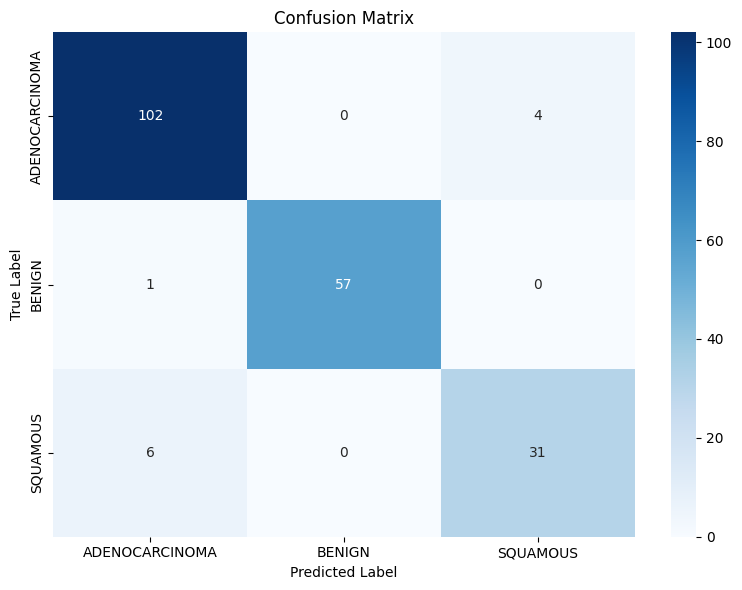

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ✅ Get predictions from your model on the validation set
Y_pred = model.predict(validate_set)
y_pred = np.argmax(Y_pred, axis=1)  # Get predicted class indices

# ✅ Get the true labels for the validation set
y_true = validate_set.classes  # Assuming 'validate_set' has 'classes' attribute

# ✅ Replace with your actual class names (if needed)
class_labels = ['ADENOCARCINOMA', 'BENIGN', 'SQUAMOUS']

# ✅ Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


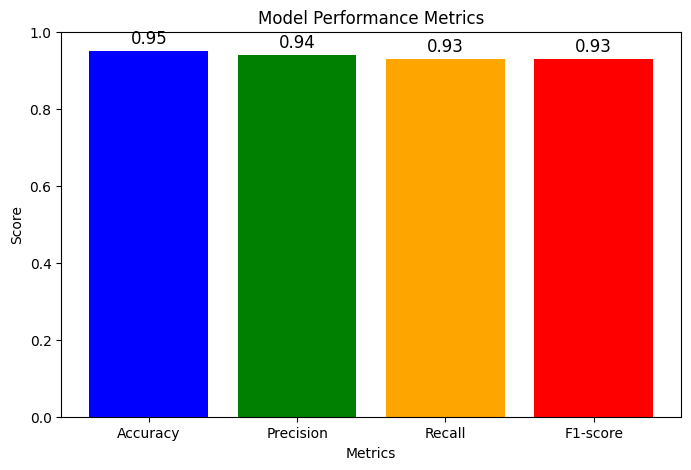

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example metric values (Replace with actual computed values)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [0.95, 0.94, 0.93, 0.93]  # Replace with actual values

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])

# Adding labels and title
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.ylim(0, 1)  # Scores range from 0 to 1
plt.title('Model Performance Metrics')

# Adding value labels on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, str(round(v, 2)), ha='center', fontsize=12)

# Show the plot
plt.show()